In [6]:
# !pip install numpy pandas matplotlib 
# opencv-python
!pip install scikit-learn

     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.6 kB ? eta -:--:--
     ------------------------- ------------ 41.0/60.6 kB 326.8 kB/s eta 0:00:01
     -------------------------------------- 60.6/60.6 kB 457.6 kB/s eta 0:00:00
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   - -------------------------------------- 0.3/11.0 MB 8.3 MB/s eta 0:00:02
   --- ------------------------------------ 0.8/11.0 MB 10.6 MB/s eta 0:00:01
   --- ------------------------------------ 1.1/11.0 MB 9.9 MB/s eta 0:00:01
   ---- ----------------------------------- 1.3/11.0 MB 8.4 MB/s eta 0:00:02
   ----- ---------------------------------- 1.5/11.0 MB 7.4 MB/s eta 0:00:02
   ------ --------------------------------- 1.8/11.0 MB 7.0 MB/s eta 0:00:02
   ------- -------------------------------- 2.0/11.0 MB 6.7 MB/s eta 0:00:02
   -------- -

In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
import os

In [3]:
print(f"Tensor Flow Version: {tf.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.16.1

GPU is NOT AVAILABLE


In [3]:
data = pd.read_csv("hand_coordinates.csv")

In [4]:
data.columns

Index(['Image', 'Gesture'], dtype='object')

In [5]:
test = data["Image"][0]

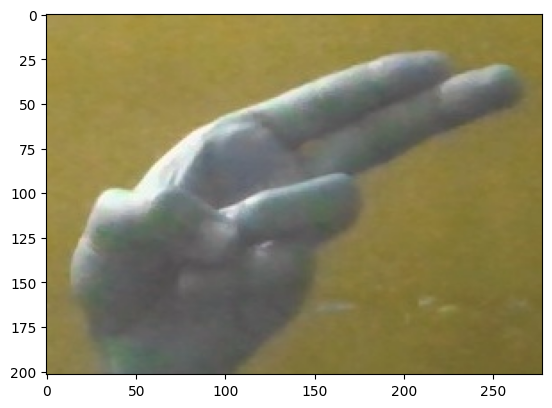

In [6]:
img = cv2.imread(test)
plt.imshow(img)

In [7]:
data["Gesture"].unique()

array(['backward', 'brightness', 'forward', 'next', 'NoGesture',
       'pointer', 'previous', 'volume'], dtype=object)

In [8]:
data["Gesture"].value_counts()

Gesture
brightness    138
volume        129
pointer       110
forward        93
backward       83
NoGesture      73
next           70
previous       68
Name: count, dtype: int64

In [9]:
backward = data[data["Gesture"] == "backward"].sample(n=70, random_state=42, replace=True).reset_index(drop=True)

In [10]:
backward = data[data["Gesture"] == "backward"].reset_index().sample(n=70, random_state=42, replace=True).reset_index(drop=True).drop(columns=["index"], axis=1)
brightness = data[data["Gesture"] == "brightness"].reset_index().sample(n=70, random_state=42, replace=True).reset_index(drop=True).drop(columns=["index"], axis=1)
forward = data[data["Gesture"] == "forward"].reset_index().sample(n=70, random_state=42, replace=True).reset_index(drop=True).drop(columns=["index"], axis=1)
Next = data[data["Gesture"] == "next"].reset_index().sample(n=70, random_state=42, replace=True).reset_index(drop=True).drop(columns=["index"], axis=1)
no_gesture = data[data["Gesture"] == "NoGesture"].reset_index().sample(n=70, random_state=42, replace=True).reset_index(drop=True).drop(columns=["index"], axis=1)
pointer = data[data["Gesture"] == "pointer"].reset_index().sample(n=70, random_state=42, replace=True).reset_index(drop=True).drop(columns=["index"], axis=1)
previous = data[data["Gesture"] == "previous"].reset_index().sample(n=68, random_state=42, replace=True).reset_index(drop=True).drop(columns=["index"], axis=1)
volume = data[data["Gesture"] == "volume"].reset_index().sample(n=70, random_state=42, replace=True).reset_index(drop=True).drop(columns=["index"], axis=1)

In [11]:
volume.head()

,Image,Gesture
0,detected_hands\Volume_73.jpg,volume
1,detected_hands\Volume_61.jpg,volume
2,detected_hands\Volume_112.jpg,volume
3,detected_hands\Volume_77.jpg,volume
4,detected_hands\Volume_30.jpg,volume


In [12]:
new_data = pd.concat([backward, brightness, forward, Next, no_gesture, pointer, previous, volume], ignore_index=True)
new_data.reset_index(drop=True, inplace=True)
# Shuffling the data
new_data = new_data.sample(frac=1, random_state=42).reset_index(drop=True)
new_data.head()

,Image,Gesture
0,detected_hands\Forward_20.jpg,forward
1,detected_hands\Previous_56.jpg,previous
2,detected_hands\Backward_92.jpg,backward
3,detected_hands\Next_66.jpg,next
4,detected_hands\Brightness_58.jpg,brightness


In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
new_data["Gesture"] = label_encoder.fit_transform(new_data["Gesture"])
new_data.head()

,Image,Gesture
0,detected_hands\Forward_20.jpg,3
1,detected_hands\Previous_56.jpg,6
2,detected_hands\Backward_92.jpg,1
3,detected_hands\Next_66.jpg,4
4,detected_hands\Brightness_58.jpg,2


In [14]:
def load_image(image_path:str):
    img = cv2.imread(image_path)
    img = tf.image.rgb_to_grayscale(img)
    resized_shape = (200, 200)
    resize = tf.image.resize(img, resized_shape)
    resize = resize / 255.0
    mean = tf.math.reduce_mean(resize)
    std = tf.math.reduce_std(tf.cast(resize, tf.float32))
    normalized_img = tf.cast((resize - mean), tf.float32) / std
    
    return normalized_img

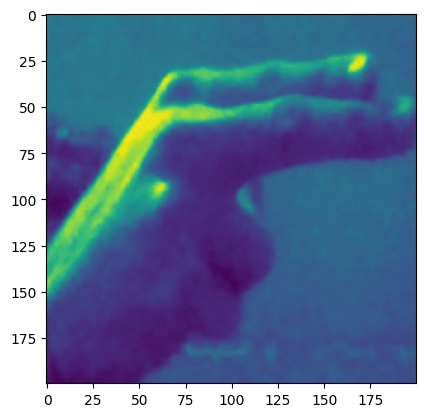

In [15]:
selected_data = new_data.iloc[0]
image_data = selected_data["Image"]
Label_data = selected_data["Gesture"]

output_image = load_image(image_path=image_data)

plt.imshow(output_image)

In [16]:
new_data.head()

,Image,Gesture
0,detected_hands\Forward_20.jpg,3
1,detected_hands\Previous_56.jpg,6
2,detected_hands\Backward_92.jpg,1
3,detected_hands\Next_66.jpg,4
4,detected_hands\Brightness_58.jpg,2


In [17]:
from tensorflow.keras.utils import  to_categorical
to_categorical(new_data["Gesture"].values).shape

(558, 8)

In [18]:
ind_var = new_data["Image"].values
dep_var = to_categorical(new_data["Gesture"].values)

# dataset = tf.data.Dataset.from_tensor_slices((ind_var, dep_var))
# dataset = dataset.map(load_image_and_label)
# B_SIZE = 32
# dataset = dataset.shuffle(buffer_size=len(new_data)).batch(batch_size=B_SIZE)

In [19]:
dep_var.shape

(558, 8)

In [20]:
# test1 = dataset.as_numpy_iterator()
# valid = test1.next()
# image_paths = tf.convert_to_tensor(valid[0]).numpy().decode('utf-8')
# image, label = load_image_and_label(image_paths, valid[1])

In [21]:
# Define a function to preprocess each data point
def preprocess_data(image_path, label):
    # Decode image path from bytes to string
    image_path =  tf.convert_to_tensor(image_path).numpy().decode('utf-8')
    
    # Load and preprocess the image
    image = load_image(image_path)
    label = tf.cast(label, dtype=tf.int32)
    
    return image, label

# Create a TensorFlow dataset from the input and output variables
dataset = tf.data.Dataset.from_tensor_slices((ind_var, dep_var))

# Map the preprocess_data function to each element of the dataset
dataset = dataset.shuffle(279, reshuffle_each_iteration=False)
dataset = dataset.map(lambda x, y: tf.py_function(preprocess_data, [x, y], [tf.float32, tf.int32]))
dataset = dataset.padded_batch(2, padded_shapes=([None,None,None],[8]))
dataset = dataset.prefetch(tf.data.AUTOTUNE)
# Added for split
train = dataset.take(220)
test = dataset.skip(220)

In [22]:
test1 = train.as_numpy_iterator()

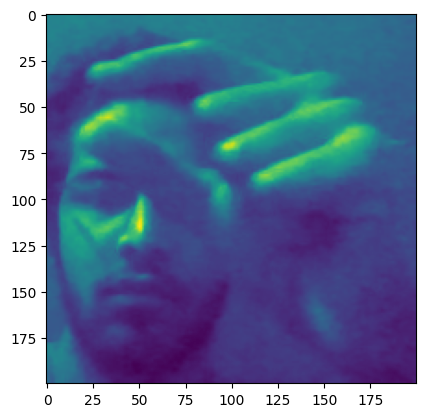

In [23]:
valid = test1.next()
plt.imshow(valid[0][0])

In [24]:
len(train)

220

In [25]:
valid[1][0].shape[0]

8

In [26]:
np.argmax(valid[1][0])

7

In [27]:
dataset.as_numpy_iterator().next()[0].shape

(2, 200, 200, 1)

In [28]:
input_shape = train.as_numpy_iterator().next()[0][0].shape

In [29]:
input_shape

(200, 200, 1)

In [30]:
num_classes = train.as_numpy_iterator().next()[1][0].shape[0]

In [31]:
num_classes

8

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPool2D, Activation, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint 

In [33]:
model = Sequential()
model.add(Conv2D(128, 2, input_shape=input_shape, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(.5))

model.add(Conv2D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool2D((2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 128)     640       
                                                                 
 activation (Activation)     (None, 200, 200, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 256)     295168    
                                                                 
 activation_1 (Activation)   (None, 100, 100, 256)     0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 256)      0         
 2D)                                                    

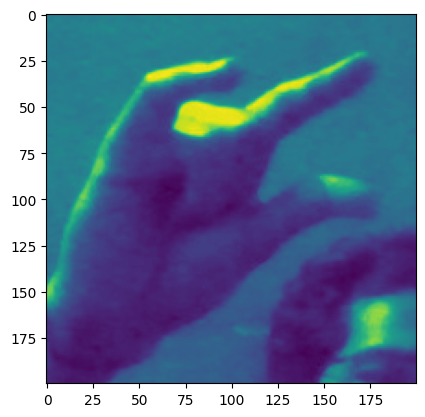

In [35]:
plt.imshow(valid[0][1])

In [36]:
y_hat = model.predict(valid[0])

1/1 [==============================] - 8s 8s/step


In [37]:
prediction = np.argmax(y_hat, axis=1)
prediction[0]

7

### Setup training options and train

Defining a scheduler function to adjust the learning rate

In [38]:
def sceduler(epoch,lr):
    if epoch<30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

Class to pass on the data into the model

In [39]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = np.argmax(yhat, axis=1)
        for x in range(len(yhat)):
            print('Original:', np.argmax(data[1][x]))
            print('Prediction:', decoded[x])
            print('~'*100)

Checkpoints to save the weights of the model

In [40]:
# checkpoint_callback = ModelCheckpoint(os.path.join('checkpoint', 'weights.h5'), monitor='loss', save_weights_only=True)

Initializing the learning rate scheduler

In [41]:
# schedule_callback=LearningRateScheduler(sceduler)

Initializing the class to pass the data into the model

In [42]:
# example_callback=ProduceExample(test)

compile the model with relevant optimizer, learning rate, loss and evaluation metric

In [43]:
# model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
# model.fit(train, validation_data=test, epochs=20, callbacks=[checkpoint_callback, schedule_callback, example_callback])

### Load the weights of the model

In [71]:
model.load_weights("checkpoint\weights.h5")

Evaluating the model on test data

In [72]:
test_data = test.as_numpy_iterator()

In [73]:
sample = test_data.next()

In [74]:
type(sample[0])

numpy.ndarray

### Model prediction

In [75]:
yhat = model.predict(sample[0])

1/1 [==============================] - 0s 49ms/step


In [76]:
print('~'*50, 'REAL GESTURE','~'*50)
[np.argmax(gesture) for gesture in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL GESTURE ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


[4, 2]

In [77]:
print('~'*50, 'PREDICTED GESTURE','~'*50)
[np.argmax(gesture) for gesture in yhat]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTED GESTURE ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


[4, 2]

### Prediction on sample data

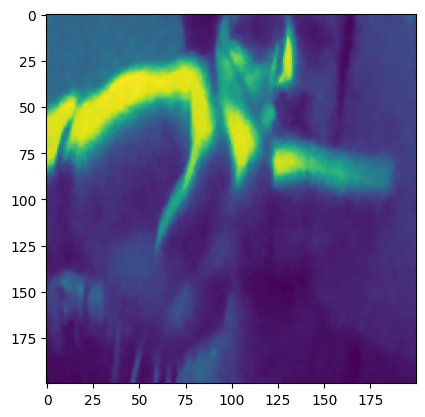

In [78]:
image_path = "detected_hands/Backward_67.jpg"
sample_image = load_image(image_path)
plt.imshow(sample_image)

In [79]:
yhat = model.predict(tf.expand_dims(sample_image, axis=0))

1/1 [==============================] - 0s 39ms/step


Determining the predicted gesture

In [80]:
print('~'*50, 'PREDICTED GESTURE','~'*50)
(np.argmax(yhat))

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTED GESTURE ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


1

In [81]:
# label_encoder.inverse_transform([np.argmax(yhat)])

Storing the gesture name (key) and its encoded value in a dictionary

In [82]:
gesture_class = {}
for encoded_value, gesture_name in enumerate(label_encoder.classes_):
    if gesture_name not in gesture_class:
        gesture_class[encoded_value] = gesture_name

In [83]:
gesture_class

{0: 'NoGesture',
 1: 'backward',
 2: 'brightness',
 3: 'forward',
 4: 'next',
 5: 'pointer',
 6: 'previous',
 7: 'volume'}

In [85]:
predicted_class = gesture_class[np.argmax(yhat)]
predicted_class

'backward'

In [1]:
import mediapipe as mp 
mp.__version__

'0.10.14'